# **_Stroke Prediction Project_**

Sirisha Mandava, Jeff Boczkaja, Mohamed Altoobli, Jesse Kranyak

Utilizing the Stroke Prediction Dataset from Kaggle we set out to make a machine learning program that will be able to accurately predict whether or not someone will have a stroke. We try out different models that provided us with varying results. We show our results using a few different metrics including balanced accuracy score, F1 scores, precision, and recall.

Source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

## What do the metrics measure?

### <u>Precision</u>
Precision measures the accuracy of positive predictions. It is the ratio of true positive predictions to the total number of positive predictions made. In other words, it answers the question, "Of all the instances the model predicted as positive, how many are actually positive?" Precision is particularly important in scenarios where the cost of a false positive is high.

Formula: Precision = True Positives / (True Positives + False Positives)

### <u>Recall</u>
Recall, also known as sensitivity or true positive rate, measures the ability of a model to find all the relevant cases within a dataset. It is the ratio of true positive predictions to the total number of actual positives. Recall answers the question, "Of all the actual positives, how many did the model successfully identify?" Recall is crucial in situations where missing a positive instance is costly.

Formula: Recall = True Positives / (True Positives + False Negatives)

### <u>F1 Score</u>
The F1 Score is the mean of precision and recall. It provides a single metric that balances both the precision and recall of a classification model, which is particularly useful when you want to compare two or more models. The F1 Score is especially valuable when the distribution of class labels is imbalanced. A high F1 Score indicates that the model has low false positives and low false negatives, so it's correctly identifying real positives and negatives.

Formula: F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

### <u>Balanced Accuracy Score</u>
Balanced Accuracy Score is defined as the average of recall obtained on each class, meaning it considers both the true positive rate and the true negative rate. It calculates the accuracy of the model by taking into account the balance between classes. For a binary classification problem, it would be the average of the proportion of correctly predicted positive observations to the total positive observations and the proportion of correctly predicted negative observations to the total negative observations.

Formula: Balanced Accuracy Score = (1/2) * ((TP / (TP + FN)) + (TN / (TN + FP)))

In [1]:
!pip install optuna
!pip install tensorflow --upgrade


In [2]:
!pip install --upgrade tensorflow-datasets tensorflow-hub tensorflow-io-gcs-filesystem tensorflow-metadata tensorflow-probability


  Using cached tensorflow-2.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
  Using cached tensorboard-2.15.2-py3-none-any.whl (5.5 MB)
  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.3.2
    Uninstalling keras-3.3.2:
      Successfully uninstalled keras-3.3.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1


# Main Project

## 1. Importing Data

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

In [4]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## 2. Analyzing and Exploring our Data

In [5]:
#Lets go ahead and loop through all of our columns and see what data they reveal

def describe_df(df: pd.DataFrame):
    print(f"The dataset contains {df.shape[1]} columns and {len(df)} rows")
    for col in df.columns:
        col_dtype = df[col].dtype
        print(f"\nColumn: {col} ({col_dtype})")
        if col_dtype == 'object':
            print(f"--- Percentage of NaNs: {df[col].isna().sum() / len(df[col]) * 100}")
            print(f"--- Unique values:\n {df[col].unique()}")
        else:
            print(f"--- Summary statistics:\n {df[col].describe()}")
describe_df(df)

The dataset contains 12 columns and 5110 rows

Column: id (int64)
--- Summary statistics:
 count     5110.000000
mean     36517.829354
std      21161.721625
min         67.000000
25%      17741.250000
50%      36932.000000
75%      54682.000000
max      72940.000000
Name: id, dtype: float64

Column: gender (object)
--- Percentage of NaNs: 0.0
--- Unique values:
 ['Male' 'Female' 'Other']

Column: age (float64)
--- Summary statistics:
 count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

Column: hypertension (int64)
--- Summary statistics:
 count    5110.000000
mean        0.097456
std         0.296607
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: hypertension, dtype: float64

Column: heart_disease (int64)
--- Summary statistics:
 count    5110.000000
mean        0.054012
std        

### Check balance of our target which is 'stroke'

In [6]:
df['stroke'].value_counts() # We have pretty imbalanced data!

stroke
0    4861
1     249
Name: count, dtype: int64

### Drop unneeded column of 'id'

In [7]:
df = df.drop('id', axis=1)

### Check nulls and use Imputation to replace them

In [8]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [9]:
df_original = df.copy()

In [10]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Create an imputer object with a mean filling strategy
mean_imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the 'bmi' column
df['bmi'] = mean_imputer.fit_transform(df[['bmi']])

# Check if any null values remain
print(df['bmi'].isnull().sum())

0


Lets see if that was the best method

In [11]:
print("After Imputation:")
print(df['bmi'].describe())
print("Before Imputation:")
print(df_original['bmi'].describe())

After Imputation:
count    5110.000000
mean       28.893237
std         7.698018
min        10.300000
25%        23.800000
50%        28.400000
75%        32.800000
max        97.600000
Name: bmi, dtype: float64
Before Imputation:
count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64


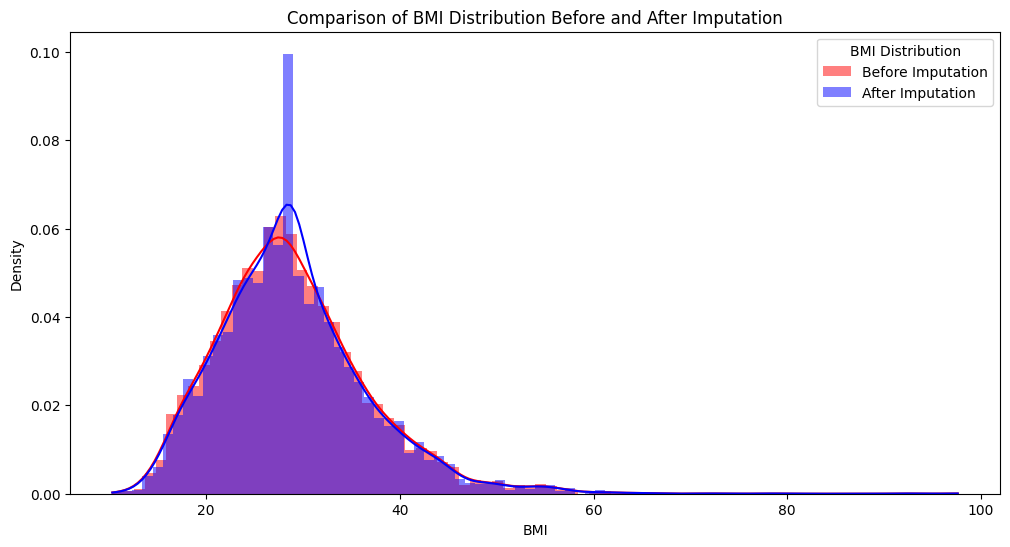

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.histplot(df_original['bmi'], color="red", label="Before Imputation", kde=True, stat="density", linewidth=0)
sns.histplot(df['bmi'], color="blue", label="After Imputation", kde=True, stat="density", linewidth=0)
plt.legend(title="BMI Distribution")
plt.title("Comparison of BMI Distribution Before and After Imputation")
plt.xlabel("BMI")
plt.ylabel("Density")
plt.show()
#

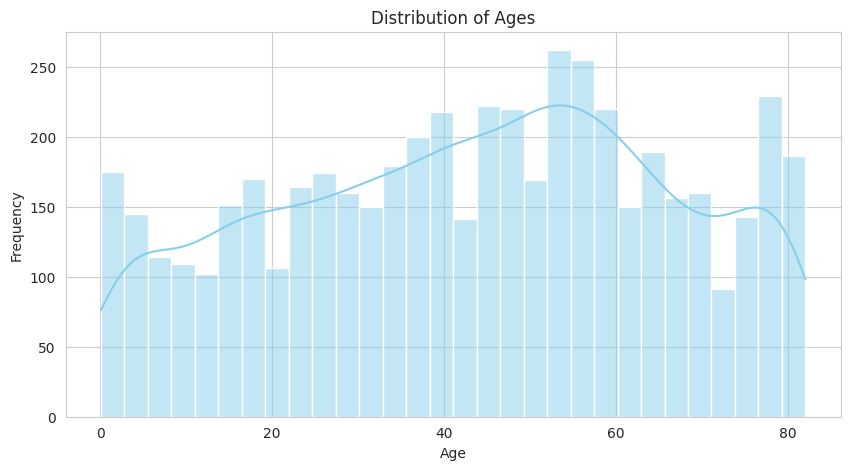

In [13]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plotting the distribution of ages
plt.figure(figsize=(10, 5))
sns.histplot(df['age'], bins=30, kde=True, color="skyblue")
plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

### Heatmap of Numerical Factors

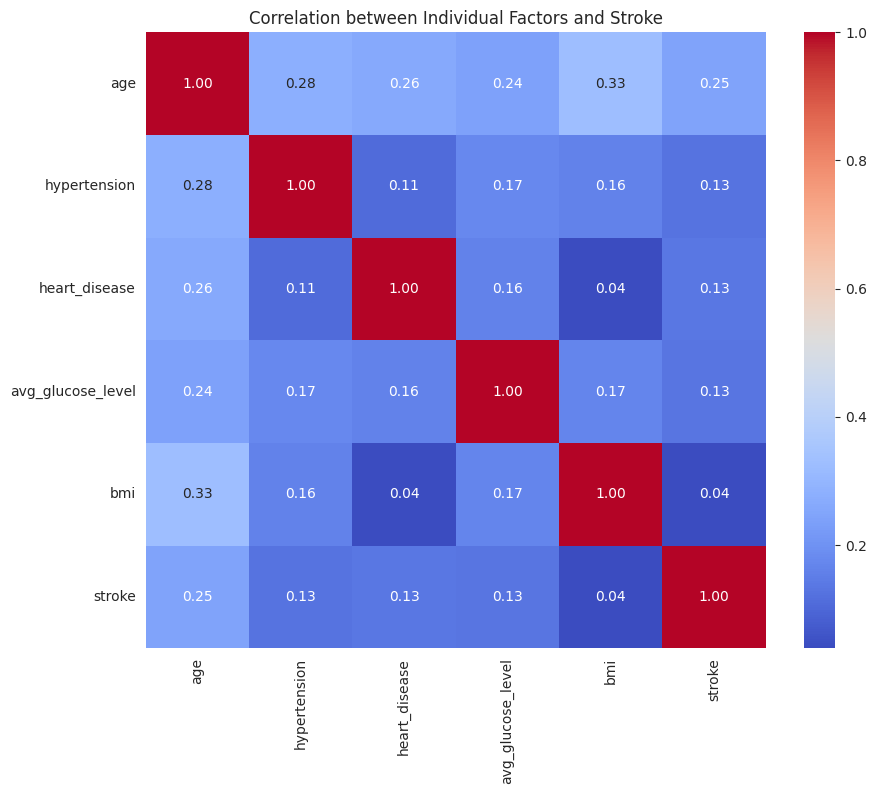

In [14]:
df_corr = df.drop(['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], axis=1)

corr = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Individual Factors and Stroke')
plt.show()

### Glucose Levels by Different Age Groups

<ipython-input-15-0bbdd13fad17>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='age_group', y='avg_glucose_level', data=df, palette="coolwarm")


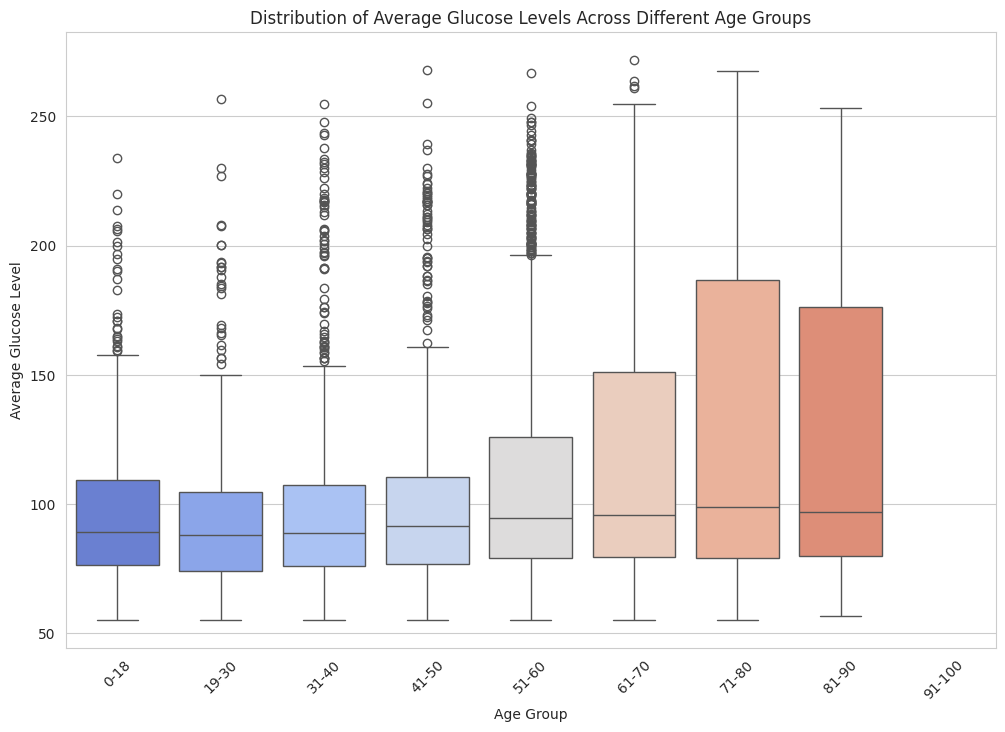

In [15]:
# Creating age groups
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'])

plt.figure(figsize=(12, 8))
sns.boxplot(x='age_group', y='avg_glucose_level', data=df, palette="coolwarm")
plt.title('Distribution of Average Glucose Levels Across Different Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Average Glucose Level')
plt.xticks(rotation=45)
plt.show()

## Who is having the strokes?

In [16]:
# Calculate the minimum age of someone who had a stroke
min_age_stroke = df[df['stroke'] == 1]['age'].min()
print(f'Youngest person in data with stroke: {min_age_stroke} years')

Youngest person in data with stroke: 1.32 years


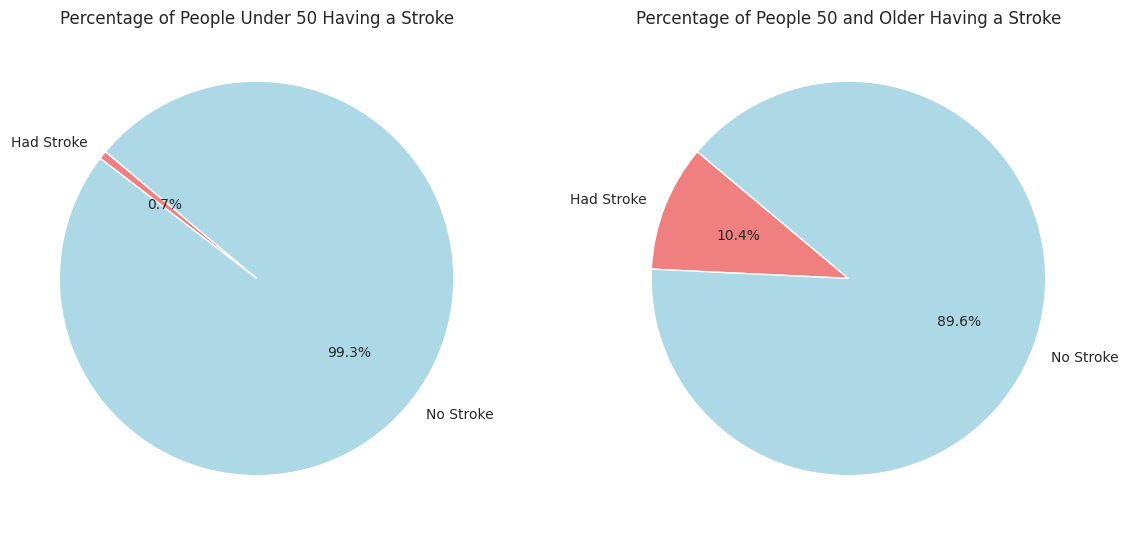

In [17]:
# # Assuming 'df' is your DataFrame containing the stroke data
# min_age_stroke = df[df['stroke'] == 1]['age'].min()

under_50_stroke = df[(df['age'] < 50) & (df['stroke'] == 1)].shape[0]
total_under_50 = df[df['age'] < 50].shape[0]
percentage_under_50_stroke = (under_50_stroke / total_under_50) * 100

over_50_stroke = df[(df['age'] >= 50) & (df['stroke'] == 1)].shape[0]
total_over_50 = df[df['age'] >= 50].shape[0]
percentage_over_50_stroke = (over_50_stroke / total_over_50) * 100

# Pie Charts for strokes based on age
labels = ['Had Stroke', 'No Stroke']
sizes_under_50 = [percentage_under_50_stroke, 100 - percentage_under_50_stroke]
sizes_over_50 = [percentage_over_50_stroke, 100 - percentage_over_50_stroke]
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Pie chart for individuals under 50
axs[0].pie(sizes_under_50, labels=labels, autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'lightblue'])
axs[0].set_title('Percentage of People Under 50 Having a Stroke')

# Pie chart for individuals 50 and older
axs[1].pie(sizes_over_50, labels=labels, autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'lightblue'])
axs[1].set_title('Percentage of People 50 and Older Having a Stroke')

plt.show()

## 3. Encoding our data for use in machine learning

In machine learning, encoding data is essential for preparing categorical variables to be used as input in algorithms. Since most machine learning models require numerical data, categorical variables such as gender, smoking status, or work type need to be encoded into numerical form. This process ensures that the model can effectively interpret and learn from these features, enabling it to make accurate predictions or classifications based on the input data.

### Check data types, we will convert objects into categorical variables to be encoded

In [18]:
df.dtypes

gender                 object
age                   float64
hypertension            int64
heart_disease           int64
ever_married           object
work_type              object
Residence_type         object
avg_glucose_level     float64
bmi                   float64
smoking_status         object
stroke                  int64
age_group            category
dtype: object

In [19]:
# Define categorical features for encoding
catFeatures = ['gender','ever_married','work_type','Residence_type','smoking_status']
# Describe the categorical features to see the number of unique categories in each
df[catFeatures].describe(include='all').loc['unique', :]

gender            3
ever_married      2
work_type         5
Residence_type    2
smoking_status    4
Name: unique, dtype: object

### Convert objects to categorical variables

In [20]:
# Convert categorical columns to 'category' dtype for efficient encoding
df[['gender','ever_married','work_type','Residence_type','smoking_status']] = df[['gender','ever_married','work_type','Residence_type','smoking_status']].astype('category')
df.dtypes

gender               category
age                   float64
hypertension            int64
heart_disease           int64
ever_married         category
work_type            category
Residence_type       category
avg_glucose_level     float64
bmi                   float64
smoking_status       category
stroke                  int64
age_group            category
dtype: object

In [21]:
# Encode categorical features as integers
for column in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    df[column] = df[column].astype('category').cat.codes

In [22]:
# Print the unique values in the encoded categorical columns for verification
for column in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    unique_values = df[column].unique()
    print(f"Unique values in '{column}': {unique_values}")

Unique values in 'gender': [1 0 2]
Unique values in 'ever_married': [1 0]
Unique values in 'work_type': [2 3 0 4 1]
Unique values in 'Residence_type': [1 0]
Unique values in 'smoking_status': [1 2 3 0]


### Check counts on gender, see if it is significant

In [23]:
# Check the distribution of values in the 'gender' column
df['gender'].value_counts() # We'll treat it as a binary!

gender
0    2994
1    2115
2       1
Name: count, dtype: int64

In [24]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1,61-70
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1,61-70
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1,71-80
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1,41-50
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1,71-80


### Create synthetic balance in the dataset using SMOTE

Due to the imbalance in our dataset we utilize SMOTE and SMOTENC to create synthetic data to improve the outcomes of our machine learning models.

**You can choose either model, press 'ctrl + /' to uncomment or comment out code choice.** \
Rerun model with new choices for different outcomes

## SMOTE
We will use SMOTE and create synthetic data for both training and test.

In [25]:
oversampled = SMOTE()
eval_df = df[['gender','age','hypertension','heart_disease','smoking_status','avg_glucose_level','bmi','stroke']].sample(int(df.shape[0]*0.2),random_state=42)
train_df = df.drop(index=eval_df.index)

X_test,y_test = eval_df[['gender','age','hypertension','heart_disease','smoking_status','avg_glucose_level','bmi']], eval_df['stroke']
X_train,y_train = train_df[['gender','age','hypertension','heart_disease','smoking_status','avg_glucose_level','bmi']], train_df['stroke']


X_train, y_train = oversampled.fit_resample(X_train,y_train)
usampled_df = X_train.assign(Stroke = y_train)

X_test,y_test = oversampled.fit_resample(X_test,y_test)
usampled_eval_df = X_test.assign(Stroke = y_test)

## SMOTENC
Another option is to use SMOTENC that creates only synthetic data for the training data

In [26]:
# # Run train test split
# X = df.drop(['stroke'], axis=1)
# y = df['stroke']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=85)

In [27]:
# oversample = SMOTENC(categorical_features=[0,2,3,4,5,6,9],
#                     random_state=27,  # for reproducibility
#                     sampling_strategy='auto')

# X_train, y_train = oversample.fit_resample(X_train, y_train)
# X_test, y_test = oversample.fit_resample(X_test, y_test)

# print('Original class distribution: \n')
# print(y_train.value_counts())
# print('-----------------------------------------')
# print('Synthetic sample class distribution: \n')
# print(pd.Series(y_train_res).value_counts())

## 4. Choose scaling method

**You can choose either model, press 'ctrl + /' to uncomment or comment out code choice.**

 <u>Normalization<u/> rescales the features to a fixed range, usually 0 to 1.

Advantages:

 - Useful when you need to bound your values between a specific range.
 - Maintains the original distribution without distorting differences in the ranges of values.

Disadvantages:

 - If your data contains outliers, normalization can squash the "normal" data into a small portion of the range, reducing the      algorithm's ability to learn from it.

<u>Standardization<u/> rescales data so that it has a mean of 0 and a standard deviation of 1.

Advantages:

 - Standardization does not bound values to a specific range, which might be useful for certain algorithms that assume no specific range.
 - More robust to outliers compared to normalization.

Disadvantages:

 - The resulting distribution will have a mean of 0 and a standard deviation of 1, but it might not be suitable for algorithms that expect input data to be within a bounded range.

### Normalization

In [28]:
# from sklearn.preprocessing import MinMaxScaler

# # Selecting numerical columns that need normalization
# numerical_cols = ['age', 'avg_glucose_level', 'work_type', 'bmi', 'smoking_status']

# # Initialize the MinMaxScaler
# scaler = MinMaxScaler()

# # Fit on training data
# scaler.fit(X_train[numerical_cols])

# # Transform both training and testing data
# X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
# X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

### Standardization

In [29]:
from sklearn.preprocessing import StandardScaler

# Selecting numerical columns that need normalization
numerical_cols = ['age', 'avg_glucose_level', 'smoking_status', 'bmi']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training data
scaler.fit(X_train[numerical_cols])

# Transform both training and testing data
X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [30]:
# Verify processing worked
X_train.head(3)

,gender,age,hypertension,heart_disease,smoking_status,avg_glucose_level,bmi
0,1,0.536723,0,1,-0.275981,2.037278,1.083414
1,0,0.266183,0,0,0.760209,1.547193,-0.081926
2,1,1.122893,0,1,0.760209,-0.234918,0.463453


In [31]:
# Verify processing worked
X_test.head(3)

,gender,age,hypertension,heart_disease,smoking_status,avg_glucose_level,bmi
0,1,-1.086518,0,0,-1.312170,-0.995031,-0.973042
1,1,-0.680708,0,0,0.760209,-0.986888,-0.171629
2,0,-2.123588,0,0,-1.312170,-0.817912,-1.048647


In [32]:
display(X_train.shape)
display(X_train.info())
display(X_train.describe())
display(X_train.columns)

(7802, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7802 entries, 0 to 7801
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7802 non-null   int8   
 1   age                7802 non-null   float64
 2   hypertension       7802 non-null   int64  
 3   heart_disease      7802 non-null   int64  
 4   smoking_status     7802 non-null   float64
 5   avg_glucose_level  7802 non-null   float64
 6   bmi                7802 non-null   float64
dtypes: float64(4), int64(2), int8(1)
memory usage: 373.5 KB


None

,gender,age,hypertension,heart_disease,smoking_status,avg_glucose_level,bmi
count,7802.000000,7.802000e+03,7802.000000,7802.000000,7.802000e+03,7.802000e+03,7.802000e+03
mean,0.307229,-2.331440e-16,0.081133,0.048705,5.100025e-17,1.020005e-16,-3.934305e-16
std,0.461375,1.000064e+00,0.273057,0.215265,1.000064e+00,1.000064e+00,1.000064e+00
min,0.000000,-2.477094e+00,0.000000,0.000000,-1.312170e+00,-1.175112e+00,-2.893408e+00
25%,0.000000,-6.356176e-01,0.000000,0.000000,-1.312170e+00,-7.349976e-01,-6.155995e-01
50%,0.000000,1.842643e-01,0.000000,0.000000,-2.759807e-01,-3.902675e-01,-8.192565e-02
75%,1.000000,8.974429e-01,0.000000,0.000000,7.602086e-01,4.733732e-01,4.332108e-01
max,1.000000,1.213073e+00,1.000000,1.000000,1.796398e+00,2.834036e+00,1.030722e+01


Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_status',
       'avg_glucose_level', 'bmi'],
      dtype='object')

## 5. Decision Tree

A decision tree is a hierarchical model that helps in making decisions by mapping out possible outcomes based on different conditions. It's a visual representation where each branch represents a decision based on features in the data, ultimately leading to a prediction or classification.

In [33]:
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier()
model_dt.fit(X_train,y_train)
y_pred = model_dt.predict(X_test)

In [34]:
y_pred_train = model_dt.predict(X_train)
y_pred_test = model_dt.predict(X_test)
print(y_pred_test)

[0 0 0 ... 1 0 1]


In [35]:
print('Classification Report for Testing:')
print(classification_report(y_test, y_pred_test))

Classification Report for Testing:
              precision    recall  f1-score   support

           0       0.64      0.89      0.74       960
           1       0.82      0.49      0.61       960

    accuracy                           0.69      1920
   macro avg       0.73      0.69      0.68      1920
weighted avg       0.73      0.69      0.68      1920



In [36]:
dt_bas = round(balanced_accuracy_score(y_test, y_pred),2)
print(f'Decision Tree balanced accuracy score {dt_bas}')

Decision Tree balanced accuracy score 0.69


In [37]:
# Place scores in dictionar
metrics_test = precision_recall_fscore_support(y_test, y_pred, average='binary')
dt_results = {
    'Method': 'Decision Tree',
    'Precision': round(metrics_test[0],2),
    'Recall': round(metrics_test[1],2),
    'F1 Score': round(metrics_test[2],2),
    'Balanced Accuracy': dt_bas
}

In [38]:
dt_results

{'Method': 'Decision Tree',
 'Precision': 0.82,
 'Recall': 0.49,
 'F1 Score': 0.61,
 'Balanced Accuracy': 0.69}

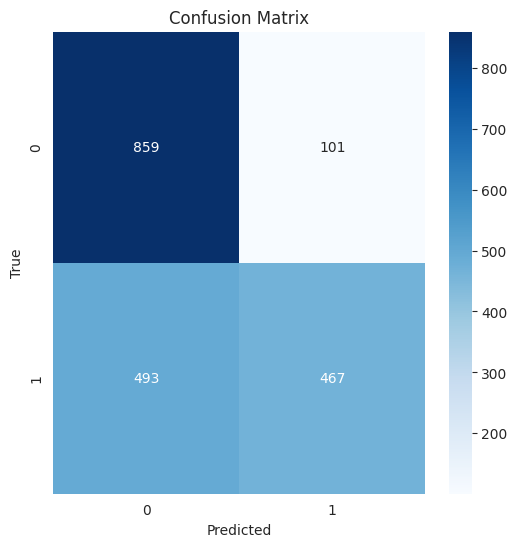

In [39]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### We will find a good max_depth to run with our model to see if we can improve

In [40]:
models = {'train_score': [], 'test_score': [], 'max_depth': []}

for depth in range(1,15):
    models['max_depth'].append(depth)
    model = DecisionTreeClassifier( max_depth=depth)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    models['train_score'].append(balanced_accuracy_score(y_train, y_train_pred))
    models['test_score'].append(balanced_accuracy_score(y_test, y_test_pred))

models_df = pd.DataFrame(models)

<Axes: xlabel='max_depth'>

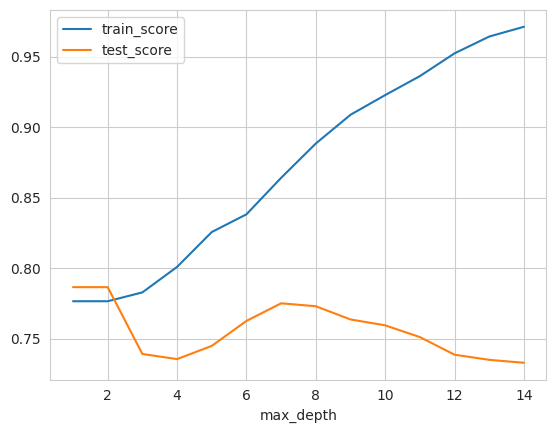

In [41]:
models_df.plot(x='max_depth')

You want to pick the max_depth where the test_score peaks.

In [42]:
model = DecisionTreeClassifier(max_depth=7, random_state=42) # Insert max_depth from above graph
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
dt_md_bas = round(balanced_accuracy_score(y_test, y_pred),2)

In [43]:
print(f'Random Forest with adjusted max_depth balanced accuracy score: {dt_md_bas}') # The tuning should increase the score!

Random Forest with adjusted max_depth balanced accuracy score: 0.77


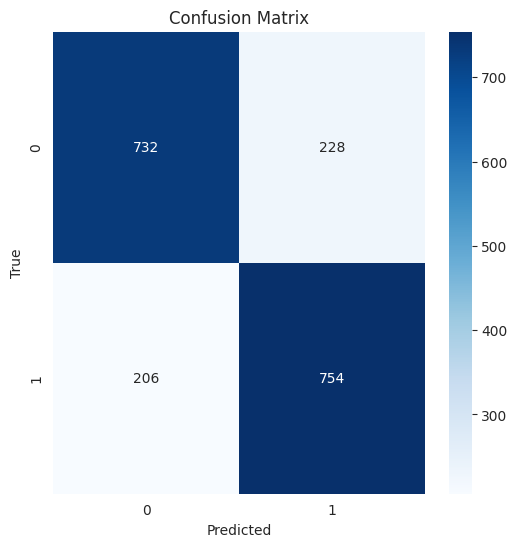

In [44]:
cm = confusion_matrix(y_test, y_pred)

# Displaying the confusion matrix as a heatmap using Seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [45]:
print('Classification Report for Testing:')
print(classification_report(y_test, y_pred_test))

Classification Report for Testing:
              precision    recall  f1-score   support

           0       0.64      0.89      0.74       960
           1       0.82      0.49      0.61       960

    accuracy                           0.69      1920
   macro avg       0.73      0.69      0.68      1920
weighted avg       0.73      0.69      0.68      1920



In [46]:
# Place scores in dictionary
metrics_test = precision_recall_fscore_support(y_test, y_pred, average='binary')
dt_md_results = {
    'Method': 'Decision Tree max_depth',
    'Precision': round(metrics_test[0],2),
    'Recall': round(metrics_test[1],2),
    'F1 Score': round(metrics_test[2],2),
    'Balanced Accuracy': dt_md_bas
}

In [47]:
dt_md_results

{'Method': 'Decision Tree max_depth',
 'Precision': 0.77,
 'Recall': 0.79,
 'F1 Score': 0.78,
 'Balanced Accuracy': 0.77}

### 5.5 PCA

Applying PCA before using a Random Forest classifier can help reduce dimensionality and computational costs, potentially improve model generalization by removing noise, but it may obscure the interpretability of feature importance and, depending on the dataset, could either improve or degrade performance. We are choosing to run it here.

In [48]:
pca_model = PCA(n_components = 7) # 7 for SMOTE, 10 for SMOTENC
pca_model.fit(X_train)

X_train_pca = pd.DataFrame(pca_model.transform(X_train))
X_test_pca = pd.DataFrame(pca_model.transform(X_test))
X_train_pca

,0,1,2,3,4,5,6
0,1.987644,-0.951291,0.798966,-0.594666,0.702449,-0.101688,0.853561
1,1.153520,-0.006617,-0.021675,-1.294050,-0.347818,-0.133695,-0.089961
2,0.928564,0.629904,-0.739540,0.379442,0.856649,-0.073352,0.900624
3,1.261074,1.390587,0.541712,-0.969089,-0.367941,-0.150719,-0.056535
4,0.927015,-0.079748,-1.188712,-1.138583,-0.207995,0.866875,-0.203889
...,...,...,...,...,...,...,...
7797,0.944618,-1.601244,1.001712,-0.093097,0.627711,-0.140614,-0.104650
7798,0.348692,-1.178660,-0.392828,1.145704,-0.206273,-0.071836,-0.032480
7799,1.564526,-1.827681,0.295824,0.085063,-0.285875,-0.124572,-0.088600
7800,2.655096,1.299288,1.207880,-0.655963,-0.316801,0.781882,-0.180879


### 6. Random Forest

A Random Forest is a machine learning method used in both classification and regression tasks. It operates by constructing a multitude of decision trees during training time and outputs the mode or average prediction of the individual trees.

In [49]:
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train_pca, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [50]:
y_test_pred = model.predict(X_test_pca)
rf_bas = round(balanced_accuracy_score(y_test, y_test_pred),2)
print(f'Random Forest balanced accuracy score: {rf_bas}')

Random Forest balanced accuracy score: 0.71


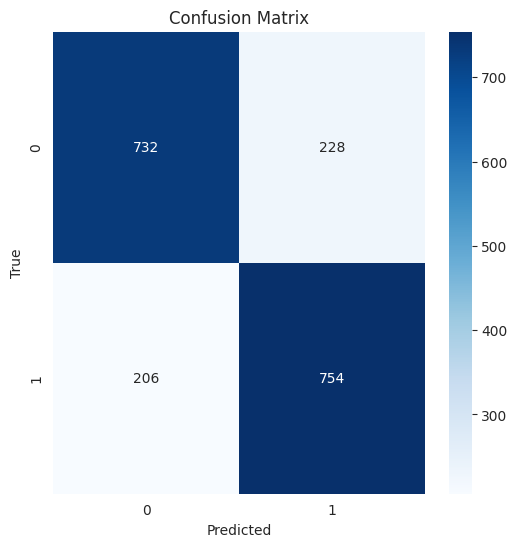

In [51]:
cm = confusion_matrix(y_test, y_pred)

# Displaying the confusion matrix as a heatmap using Seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [52]:
print('Classification Report for Testing:')
print(classification_report(y_test, y_pred_test))

Classification Report for Testing:
              precision    recall  f1-score   support

           0       0.64      0.89      0.74       960
           1       0.82      0.49      0.61       960

    accuracy                           0.69      1920
   macro avg       0.73      0.69      0.68      1920
weighted avg       0.73      0.69      0.68      1920



In [53]:
# Place scores in dictionary
metrics_test = precision_recall_fscore_support(y_test, y_pred, average='binary')
rf_results = {
    'Method': 'Random Forest',
    'Precision': round(metrics_test[0],2),
    'Recall': round(metrics_test[1],2),
    'F1 Score': round(metrics_test[2],2),
    'Balanced Accuracy': rf_bas
}

In [54]:
rf_results

{'Method': 'Random Forest',
 'Precision': 0.77,
 'Recall': 0.79,
 'F1 Score': 0.78,
 'Balanced Accuracy': 0.71}

### We will find a good max_depth to run with our model to see if we can improve

In [55]:
models = {'train_score': [], 'test_score': [], 'max_depth': []}

for depth in range(1,10):
    models['max_depth'].append(depth)
    model = RandomForestClassifier(n_estimators=100, max_depth=depth)
    model.fit(X_train_pca, y_train)
    y_test_pred = model.predict(X_test_pca)
    y_train_pred = model.predict(X_train_pca)

    models['train_score'].append(balanced_accuracy_score(y_train, y_train_pred))
    models['test_score'].append(balanced_accuracy_score(y_test, y_test_pred))

models_df = pd.DataFrame(models)

<Axes: xlabel='max_depth'>

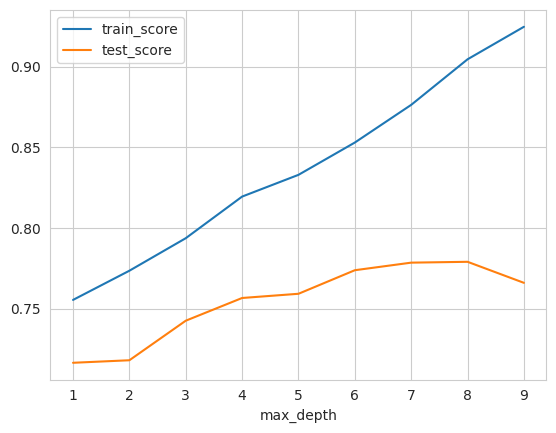

In [56]:
models_df.plot(x='max_depth')

You want to pick the max_depth where the test_score peaks.

### Apply best max_depth to Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42) # Insert max_depth from above graph
model.fit(X_train, y_train)
forest_score = model.score(X_train, y_train)
forest_test = model.score(X_test, y_test)
y_pred = model.predict(X_test)
rf_md_bas = round(balanced_accuracy_score(y_test, y_pred),2)

In [58]:
print(f'Random Forest with adjusted max_depth balanced accuracy score: {rf_md_bas}') # The tuning should increase the score!

Random Forest with adjusted max_depth balanced accuracy score: 0.81


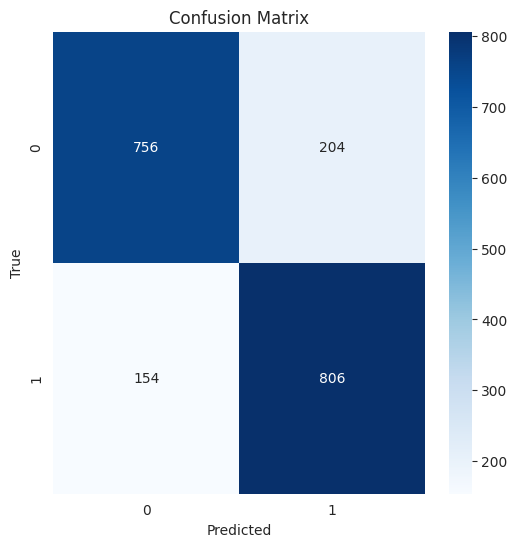

In [59]:
cm = confusion_matrix(y_test, y_pred)

# Displaying the confusion matrix as a heatmap using Seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [60]:
print('Classification Report for Testing:')
print(classification_report(y_test, y_pred_test))

Classification Report for Testing:
              precision    recall  f1-score   support

           0       0.64      0.89      0.74       960
           1       0.82      0.49      0.61       960

    accuracy                           0.69      1920
   macro avg       0.73      0.69      0.68      1920
weighted avg       0.73      0.69      0.68      1920



In [61]:
# Place scores in dictionary
metrics_test = precision_recall_fscore_support(y_test, y_pred, average='binary')
rf_md_results = {
    'Method': 'Random Forest max_depth',
    'Precision': round(metrics_test[0],2),
    'Recall': round(metrics_test[1],2),
    'F1 Score': round(metrics_test[2],2),
    'Balanced Accuracy': rf_md_bas
}

In [62]:
rf_md_results

{'Method': 'Random Forest max_depth',
 'Precision': 0.8,
 'Recall': 0.84,
 'F1 Score': 0.82,
 'Balanced Accuracy': 0.81}

## 7. K Nearest Neighbors

The k-nearest neighbors algorithm predicts the label of a data point based on the labels of its 'k' closest neighbors in the dataset. To classify a new instance, KNN calculates the distance between the instance and all points in the training set, identifies the 'k' nearest points, and then uses a majority vote among these neighbors to determine the instance's label. For regression tasks, it averages the values of these neighbors instead.

In [63]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
    'weights': ['uniform', 'distance'],
    'leaf_size': [10, 50, 100, 500]
}
random_knn = RandomizedSearchCV(KNeighborsClassifier(), param_grid, verbose=3)

random_knn.fit(X_train_pca, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END leaf_size=100, n_neighbors=15, weights=uniform;, score=0.823 total time=   0.1s
[CV 2/5] END leaf_size=100, n_neighbors=15, weights=uniform;, score=0.848 total time=   0.1s
[CV 3/5] END leaf_size=100, n_neighbors=15, weights=uniform;, score=0.835 total time=   0.1s
[CV 4/5] END leaf_size=100, n_neighbors=15, weights=uniform;, score=0.847 total time=   0.1s
[CV 5/5] END leaf_size=100, n_neighbors=15, weights=uniform;, score=0.856 total time=   0.1s
[CV 1/5] END leaf_size=500, n_neighbors=13, weights=uniform;, score=0.830 total time=   0.1s
[CV 2/5] END leaf_size=500, n_neighbors=13, weights=uniform;, score=0.859 total time=   0.1s
[CV 3/5] END leaf_size=500, n_neighbors=13, weights=uniform;, score=0.838 total time=   0.1s
[CV 4/5] END leaf_size=500, n_neighbors=13, weights=uniform;, score=0.849 total time=   0.1s
[CV 5/5] END leaf_size=500, n_neighbors=13, weights=uniform;, score=0.863 total time=   0.1s
[CV 1/5] 

RandomizedSearchCV(estimator=KNeighborsClassifier(),
                   param_distributions={'leaf_size': [10, 50, 100, 500],
                                        'n_neighbors': [1, 3, 5, 7, 9, 11, 13,
                                                        15, 17, 19],
                                        'weights': ['uniform', 'distance']},
                   verbose=3)

In [64]:
y_pred = random_knn.predict(X_test_pca)
knn_bas = round(balanced_accuracy_score(y_test, y_pred),2)
print(f'KNN balanced accuracy score: {knn_bas}')

KNN balanced accuracy score: 0.67


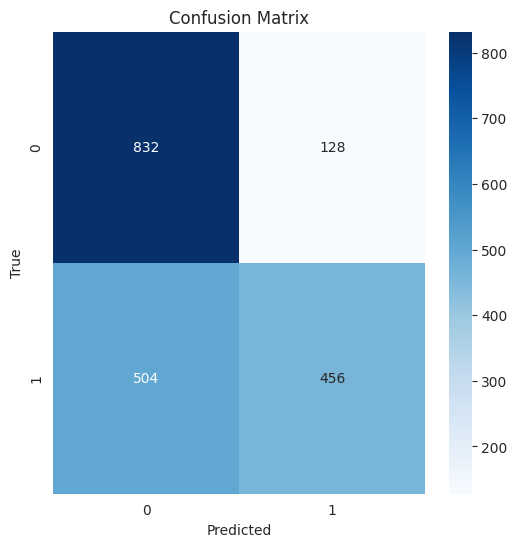

In [65]:
cm = confusion_matrix(y_test, y_pred)

# Displaying the confusion matrix as a heatmap using Seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [66]:
print('Classification Report for Testing:')
print(classification_report(y_test, y_pred_test))

Classification Report for Testing:
              precision    recall  f1-score   support

           0       0.64      0.89      0.74       960
           1       0.82      0.49      0.61       960

    accuracy                           0.69      1920
   macro avg       0.73      0.69      0.68      1920
weighted avg       0.73      0.69      0.68      1920



In [67]:
# Place scores in dictionary
metrics_test = precision_recall_fscore_support(y_test, y_pred, average='binary')
knn_results = {
    'Method': 'KNN max_depth',
    'Precision': round(metrics_test[0],2),
    'Recall': round(metrics_test[1],2),
    'F1 Score': round(metrics_test[2],2),
    'Balanced Accuracy': knn_bas
}

In [68]:
knn_results

{'Method': 'KNN max_depth',
 'Precision': 0.78,
 'Recall': 0.48,
 'F1 Score': 0.59,
 'Balanced Accuracy': 0.67}

### Let's tune our KNN

In [69]:
# Define ranges and settings to explore
n_neighbors_range = range(1, 50)
weights_options = ['uniform', 'distance']
scores = {weight: [] for weight in weights_options}

for weight in weights_options:
    for n_neighbors in n_neighbors_range:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weight)
        knn.fit(X_train_pca, y_train)
        y_pred = knn.predict(X_test_pca)
        score = balanced_accuracy_score(y_test, y_pred)
        scores[weight].append(score)

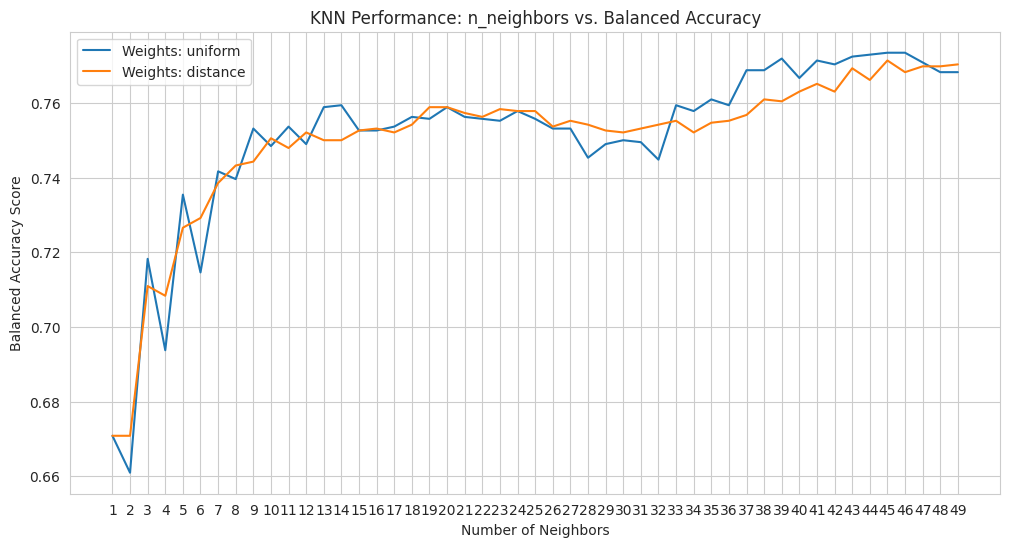

In [70]:
plt.figure(figsize=(12, 6))
for weight in weights_options:
    plt.plot(n_neighbors_range, scores[weight], label=f'Weights: {weight}')
plt.xlabel('Number of Neighbors')
plt.ylabel('Balanced Accuracy Score')
plt.legend()
plt.title('KNN Performance: n_neighbors vs. Balanced Accuracy')
plt.xticks(list(n_neighbors_range))
plt.show()

Select the either 'uniform' or 'distance' line which has the highest peak for optimal_weights, select corresponding number of neighbors for optimal_n_neighbors.

In [71]:
optimal_n_neighbors = 44 # Select fro above graph
optimal_weights = 'distance'

optimal_knn = KNeighborsClassifier(n_neighbors=optimal_n_neighbors, weights=optimal_weights)
optimal_knn.fit(X_train, y_train)
y_pred_optimal = optimal_knn.predict(X_test)

In [72]:
knn_md_bas = round(balanced_accuracy_score(y_test, y_pred_optimal),2)
print(f'KNN with adjusted neighbors accuracy score: {knn_md_bas}')

KNN with adjusted neighbors accuracy score: 0.77


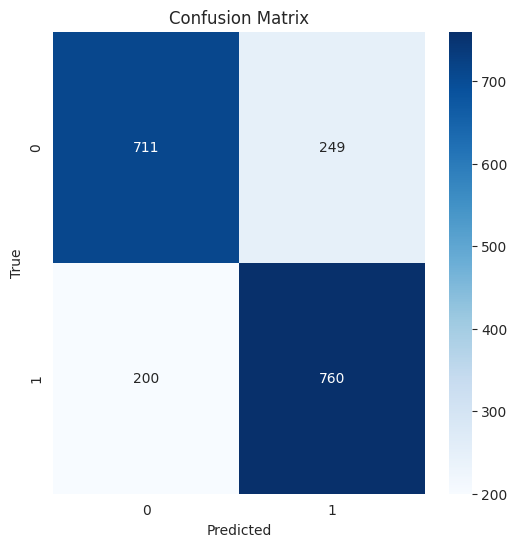

In [73]:
cm = confusion_matrix(y_test, y_pred_optimal)

# Displaying the confusion matrix as a heatmap using Seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [74]:
print('Classification Report for Testing:')
print(classification_report(y_test, y_pred_optimal))

Classification Report for Testing:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       960
           1       0.75      0.79      0.77       960

    accuracy                           0.77      1920
   macro avg       0.77      0.77      0.77      1920
weighted avg       0.77      0.77      0.77      1920



In [75]:
# Place scores in dictionary
metrics_test = precision_recall_fscore_support(y_test, y_pred_optimal, average='binary')
knn_md_results = {
    'Method': 'KNN modified neighbors',
    'Precision': round(metrics_test[0],2),
    'Recall': round(metrics_test[1],2),
    'F1 Score': round(metrics_test[2],2),
    'Balanced Accuracy': knn_md_bas
}

In [76]:
knn_md_results

{'Method': 'KNN modified neighbors',
 'Precision': 0.75,
 'Recall': 0.79,
 'F1 Score': 0.77,
 'Balanced Accuracy': 0.77}

## Conclusion

In [77]:
all_results = []
all_results.append(dt_results)
all_results.append(dt_md_results)
all_results.append(rf_results)
all_results.append(rf_md_results)
all_results.append(knn_results)
all_results.append(knn_md_results)

df_results = pd.DataFrame(all_results)
df_results.set_index('Method', inplace=True)

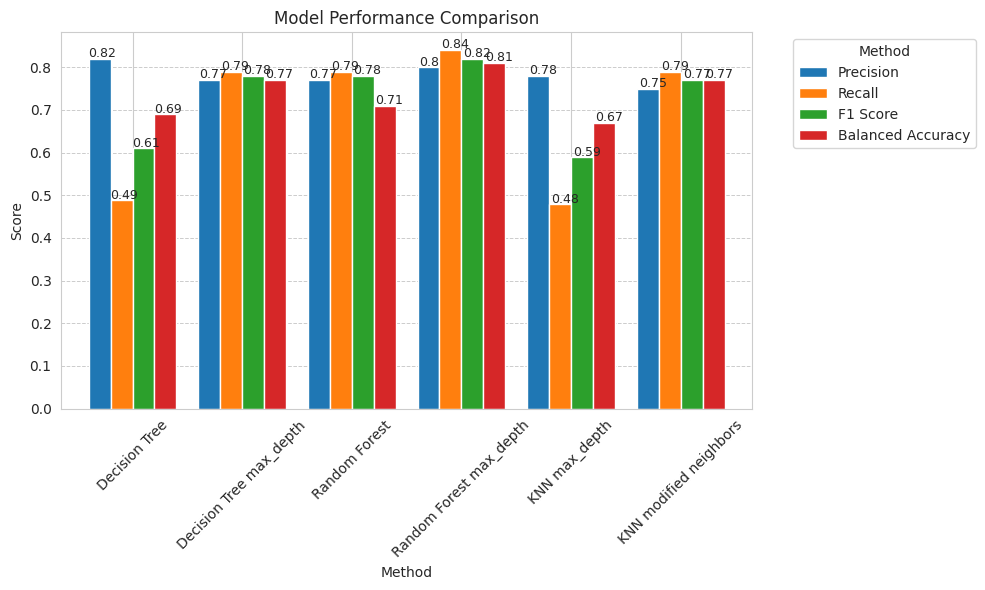

In [78]:
ax = df_results.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)

for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=9)

plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [79]:
metrics = ['Precision', 'F1 Score', 'Recall', 'Balanced Accuracy']
for metric in metrics:
    max_value = df_results[metric].max()
    max_model = df_results[df_results[metric] == max_value].index[0]
    print(f"Model with highest {metric}: {max_model} ({max_value})")

Model with highest Precision: Decision Tree (0.82)
Model with highest F1 Score: Random Forest max_depth (0.82)
Model with highest Recall: Random Forest max_depth (0.84)
Model with highest Balanced Accuracy: Random Forest max_depth (0.81)


The initial analysis of the dataset revealed a significant imbalance, raising concerns about data leakage potential. To mitigate this, we experimented with both SMOTE and SMOTENC for oversampling, with SMOTE demonstrating greater performance in addressing the imbalance.

Upon evaluating various machine learning models for classification purposes, it was observed that prior to tuning the models did not exhibit strong predictive capabilities. However post-tuning improvements were notable, particularly in terms of balanced accuracy scores. Examining other projects that used our dataset had similar findings. An interesting discovery during our investigation was that datasets incorporating bloodwork data tend to yield more accurate stroke predictions. This suggests that lifestyle-based predictive models might best serve as preliminary tools for healthcare professionals, guiding at-risk patients towards more definitive bloodwork analyses.

Despite the challenges presented by lifestyle data, the Random Forest Classifier was the standout model upon tuning, specifically when adjusted to the optimal max depth. This model achieved a balanced accuracy score of 80%, marking it as the most effective among the classifiers we tested for predicting stroke potential. The Random Forest Classifier with an appropriate max depth is what we would recommended as a tool for stroke prediction, emphasizing the model's utility in clinical settings for early stroke risk assessment.



---



---



#Deep Learning & interface
At this point in the project we can begin implementing a deep learning model for stroke prediction. We could potentially improve the performance of our predictions. Deep learning is particularly good at capturing non-linear interactions between features. Here’s how we will approach the next part of this project:

##Deep Learning Model Approach
###Data Preprocessing:
1. Normalize or standardize the input features to ensure that the model trains efficiently using One-hot encode categorical variables

###Model Architecture:
1. Use a simple feedforward neural network with several dense layers as a starting point.
2. Include dropout layers to prevent overfitting.
3. Use activation function ReLU for hidden layers and a sigmoid activation function at the output layer for binary classification (stroke or no stroke).

###Compilation:
1. Compile the model using the optimizer Adam.
2. Use binary cross-entropy as the loss function since this is a binary classification problem.
3. Track accuracy as a metric and hypertune our model using Optuna

###Training:
1. Train the model using a suitable batch size and number of epochs.
2. Utilize callbacks like ModelCheckpoint for saving the best model and EarlyStopping to halt training when performance plateaus, to overcome overfitting we will impliment a ReduceLR into our epochs

###Evaluation:
1. Evaluate the model on a validation set to check for overfitting and underfitting.
2. Adjust the model architecture and hyperparameters based on performance metrics.

###Deployment:
1. Once the model is trained and validated, deploy it in a Gradio interface to make it interactive.

##Preprocessing
###OHE
###TT&S
###Smote
###Val

In [80]:
# Bin 'BMI' into categories
df['bmi_bins'] = pd.cut(df['bmi'], bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf], labels=[0, 1, 2, 3, 4, 5])

# Bin 'avg_glucose_level' into categories based on common medical knowledge or quartiles
df['glucose_bins'] = pd.cut(df['avg_glucose_level'], bins=[0, 90, 140, 200, np.inf], labels=[0, 1, 2, 3])

# Bin 'age' into clinically meaningful categories
df['age_bins'] = pd.cut(df['age'], bins=[0, 13, 18, 40, 60, np.inf], labels=[0, 1, 2, 3, 4])


In [81]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group,bmi_bins,glucose_bins,age_bins
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1,61-70,4,3,4
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1,61-70,2,3,4
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1,71-80,3,1,4
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1,41-50,3,2,3
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1,71-80,1,2,4


In [82]:
df.drop(['bmi', 'avg_glucose_level', 'age'], axis=1, inplace=True)

In [83]:
df.drop('age_group', axis=1, inplace=True)


In [84]:
df.head()

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke,bmi_bins,glucose_bins,age_bins
0,1,0,1,1,2,1,1,1,4,3,4
1,0,0,0,1,3,0,2,1,2,3,4
2,1,0,1,1,2,0,2,1,3,1,4
3,0,0,0,1,2,1,3,1,3,2,3
4,0,1,0,1,3,0,2,1,1,2,4


In [106]:
# Convert bin columns to type 'category' if not already
df[['bmi_bins', 'glucose_bins', 'age_bins']] = df[['bmi_bins', 'glucose_bins', 'age_bins']].astype('category')

# Convert category columns to integers
df['bmi_bins'] = df['bmi_bins'].cat.codes
df['glucose_bins'] = df['glucose_bins'].cat.codes
df['age_bins'] = df['age_bins'].cat.codes

# Set stroke as the target
X = df.drop('stroke', axis=1)  # Features
y = df['stroke']  # Target

# Identify categorical columns that need one-hot encoding, excluding 'stroke'
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Apply one-hot encoding to X
X = pd.get_dummies(X, columns=categorical_cols)


In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [108]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [109]:
X_train_smote, X_val, y_train_smote, y_val = train_test_split(X_train_smote, y_train_smote, test_size=0.2, random_state=42)


In [110]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
clf = RandomForestClassifier()

# Perform cross-validation
scores = cross_val_score(clf, X_train_smote, y_train_smote, cv=5, scoring='accuracy')

# You can then see your 5 different validation scores
print(scores)


[0.90859232 0.8857404  0.89021043 0.91308326 0.89752973]


In [111]:
X_train_smote.head()

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,bmi_bins,glucose_bins,age_bins
2473,1,0,0,0,4,1,0,1,0,0
3916,0,0,0,0,2,0,2,1,0,4
257,0,0,0,1,0,1,1,2,0,3
893,1,0,0,1,2,1,3,2,2,4
3001,0,0,0,0,4,1,0,0,0,0


Looking good, but lets double check

In [112]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# Get cross-validated estimates for each data point
y_pred = cross_val_predict(clf, X_train_smote, y_train_smote, cv=5)

# Compute confusion matrix
conf_mat = confusion_matrix(y_train_smote, y_pred)
print("Confusion Matrix:")
print(conf_mat)

# Calculate precision, recall, and F1 score
precision = precision_score(y_train_smote, y_pred)
recall = recall_score(y_train_smote, y_pred)
f1 = f1_score(y_train_smote, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Compute ROC-AUC
# ROC-AUC might require probability scores instead of binary predictions, depending on your use case
y_scores = cross_val_predict(clf, X_train_smote, y_train_smote, cv=5, method='predict_proba')
roc_auc = roc_auc_score(y_train_smote, y_scores[:, 1])  # Assuming the positive class is labeled '1'

print(f"ROC-AUC Score: {roc_auc}")


Confusion Matrix:
[[2327  393]
 [ 149 2598]]
Precision: 0.8686058174523571
Recall: 0.9457590098289043
F1 Score: 0.905542000697107
ROC-AUC Score: 0.9573795745090903


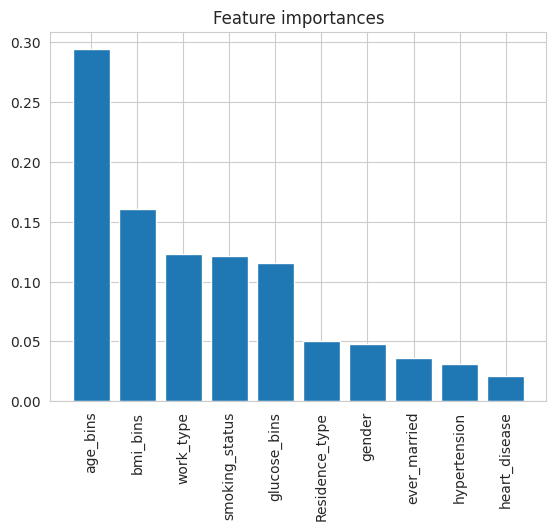

In [113]:
from sklearn.ensemble import RandomForestClassifier

# Assuming X_train_smote and y_train_smote are defined
clf = RandomForestClassifier()
clf.fit(X_train_smote, y_train_smote)

# Get feature importances
importances = clf.feature_importances_
feature_names = X_train_smote.columns

# Sort feature importances in descending order and plot
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_smote.shape[1]), importances[indices])
plt.xticks(range(X_train_smote.shape[1]), feature_names[indices], rotation=90)
plt.show()


###Model Architecture

####Model log:
Model 1:
- loss: 0.4380
- accuracy: 0.7573
- Test Loss: 0.43803343176841736
- Test Accuracy: 0.7573385238647461

Model 1.2: used binning to solve issues w age, blood glucose and bmi
- loss: 0.5950
- accuracy: 0.5564
- Test Loss: 0.59500360488891
- Test Accuracy: 0.5564253330230713.

- Precision: 0.10252996005326231
- Recall: 0.8651685393258427
- F1-Score: 0.18333333333333332
- AUC-ROC: 0.766799464658097

model 1.3: bayesian hypertuning,

model 1.3.1: ensemble with 1.3



In [139]:
!pip list | grep tensorflow


tensorflow                       2.15.1
tensorflow-addons                0.23.0
tensorflow-datasets              4.9.4
tensorflow-estimator             2.15.0
tensorflow-gcs-config            2.15.0
tensorflow-hub                   0.16.1
tensorflow-io-gcs-filesystem     0.36.0
tensorflow-metadata              1.15.0
tensorflow-probability           0.24.0


In [115]:
!pip install --upgrade tensorflow tensorflow-datasets tensorflow-estimator tensorflow-gcs-config tensorflow-hub tensorflow-io-gcs-filesystem tensorflow-metadata tensorflow-probability


  Using cached tensorflow-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.8 MB)
  Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
  Using cached keras-3.3.2-py3-none-any.whl (1.1 MB)


In [128]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the objective function for the Optuna study
def create_model(trial):
    # Hyperparameters to be tuned by Optuna
    n_layers = trial.suggest_int('n_layers', 1, 3)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    n_units_first = trial.suggest_int('n_units_first', 4, 128)

    # Additional layers
    additional_units = [trial.suggest_int(f'n_units_l{i}', 4, 128) for i in range(n_layers)]

    # Model architecture
    model = Sequential()
    model.add(Dense(n_units_first, activation='relu', input_shape=(X_train_smote.shape[1],)))
    for n_units in additional_units:
        model.add(Dense(n_units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def objective(trial):
    model = create_model(trial)

    # Early stopping and reduce learning rate on plateau callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
    ]

    # Fit the model
    history = model.fit(
        X_train_smote, y_train_smote,
        validation_data=(X_val, y_val),
        epochs=100, batch_size=32,
        callbacks=callbacks,
        verbose=0
    )

    # Evaluate the model accuracy on the validation set
    val_accuracy = model.evaluate(X_val, y_val, verbose=0)[1]
    return val_accuracy

# Create a study object and specify the direction is 'maximize'.
study = optuna.create_study(direction='maximize')

# Optimize the study, the objective function is passed in as the first argument.
study.optimize(objective, n_trials=10)

# Best trial result
best_trial = study.best_trial
print(f'Accuracy: {best_trial.value}')
print(f"Best hyperparameters: {best_trial.params}")



[I 2024-04-24 13:16:14,299] A new study created in memory with name: no-name-0eea5d10-195c-437e-8e52-f45f711d13d9
[I 2024-04-24 13:16:27,176] Trial 0 finished with value: 0.8383321166038513 and parameters: {'n_layers': 1, 'dropout_rate': 0.11025986797090398, 'lr': 0.0010878245708187525, 'n_units_first': 89, 'n_units_l0': 75}. Best is trial 0 with value: 0.8383321166038513.
[I 2024-04-24 13:16:44,084] Trial 1 finished with value: 0.8288222551345825 and parameters: {'n_layers': 3, 'dropout_rate': 0.47673970447363523, 'lr': 0.001337119271020817, 'n_units_first': 120, 'n_units_l0': 39, 'n_units_l1': 29, 'n_units_l2': 85}. Best is trial 0 with value: 0.8383321166038513.
[I 2024-04-24 13:17:12,869] Trial 2 finished with value: 0.859546422958374 and parameters: {'n_layers': 3, 'dropout_rate': 0.1931642791147507, 'lr': 0.0003865222724920752, 'n_units_first': 74, 'n_units_l0': 77, 'n_units_l1': 119, 'n_units_l2': 27}. Best is trial 2 with value: 0.859546422958374.
[I 2024-04-24 13:17:20,174] Tr

Accuracy: 0.859546422958374
Best hyperparameters: {'n_layers': 3, 'dropout_rate': 0.1931642791147507, 'lr': 0.0003865222724920752, 'n_units_first': 74, 'n_units_l0': 77, 'n_units_l1': 119, 'n_units_l2': 27}


In [129]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
#untuned 48/48 [==============================] - 0s 2ms/step - loss: 0.5950 - accuracy: 0.5564
#Test Loss: 0.595003604888916, Test Accuracy: 0.5564253330230713
# 48/48 [==============================] - 0s 2ms/step - loss: 0.5038 - accuracy: 0.8082
# Test Loss: 0.5038195848464966, Test Accuracy: 0.8082191944122314


# Building the model with optimal parameters


# Best hyperparameters
hyperparameters = {
    'n_layers': 3,
    'dropout_rate': 0.1931642791147507,
    'lr': 0.0003865222724920752,
    'n_units_first': 74,
    'n_units_l0': 77,
    'n_units_l1': 119,
    'n_units_l2': 27
}

# Define the model with hyperparameters
model = Sequential([
    Dense(hyperparameters['n_units_first'], activation='relu', input_shape=(X_train_smote.shape[1],)),  # First layer
    Dense(hyperparameters['n_units_l0'], activation='relu'),  # Second layer
    Dense(hyperparameters['n_units_l1'], activation='relu'),  # Third layer
    Dropout(hyperparameters['dropout_rate']),  # Dropout layer
    Dense(hyperparameters['n_units_l2'], activation='relu'),  # Fourth layer
    Dense(1, activation='sigmoid')  # Output layer
])

# Compile the model with the optimal learning rate
model.compile(optimizer=Adam(learning_rate=hyperparameters['lr']),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Adjust ReduceLROnPlateau to be more patient
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # Reduce the learning rate by a factor of 0.1
    patience=5,  # Increased patience
    min_lr=1e-6  # Lower bound on the learning rate
)

# Train the model with the SMOTE-augmented training data and callbacks
history = model.fit(
    X_train_smote, y_train_smote,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

# Model summary
model.summary()


Epoch 1/100
171/171 [==============================] - 2s 5ms/step - loss: 0.5703 - accuracy: 0.7110 - val_loss: 0.5283 - val_accuracy: 0.7315 - lr: 3.8652e-04
Epoch 2/100
171/171 [==============================] - 1s 4ms/step - loss: 0.4983 - accuracy: 0.7529 - val_loss: 0.4865 - val_accuracy: 0.7498 - lr: 3.8652e-04
Epoch 3/100
171/171 [==============================] - 1s 4ms/step - loss: 0.4751 - accuracy: 0.7701 - val_loss: 0.4775 - val_accuracy: 0.7593 - lr: 3.8652e-04
Epoch 4/100
171/171 [==============================] - 1s 4ms/step - loss: 0.4589 - accuracy: 0.7778 - val_loss: 0.4543 - val_accuracy: 0.7798 - lr: 3.8652e-04
Epoch 5/100
171/171 [==============================] - 1s 4ms/step - loss: 0.4468 - accuracy: 0.7831 - val_loss: 0.4476 - val_accuracy: 0.7849 - lr: 3.8652e-04
Epoch 6/100
171/171 [==============================] - 1s 4ms/step - loss: 0.4339 - accuracy: 0.7944 - val_loss: 0.4231 - val_accuracy: 0.7922 - lr: 3.8652e-04
Epoch 7/100
171/171 [===================

In [130]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")


48/48 [==============================] - 0s 2ms/step - loss: 0.5038 - accuracy: 0.8082
Test Loss: 0.5038195848464966, Test Accuracy: 0.8082191944122314


In [131]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Assuming X_train_smote and y_train_smote are pandas DataFrame and Series respectively
def build_model():
    model = Sequential([
        Dense(83, activation='relu', input_shape=(X_train_smote.shape[1],)),  # Adjust input_shape to match feature size
        Dense(121, activation='relu'),
        Dropout(0.3475302741733841),  # Adjust dropout rate if necessary
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.07826801938092297),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)

scores = []
for train, test in kfold.split(X_train_smote, y_train_smote):
    model = build_model()
    # Use .iloc for proper indexing when using pandas data structures
    model.fit(X_train_smote.iloc[train], y_train_smote.iloc[train], epochs=100, batch_size=32, verbose=0)
    score = model.evaluate(X_train_smote.iloc[test], y_train_smote.iloc[test], verbose=0)
    scores.append(score)

# Print the cross-validation scores
print(f"Cross-validated scores: {scores}")


Cross-validated scores: [[0.5268402099609375, 0.7422303557395935], [0.616553544998169, 0.6096892356872559], [0.5671566724777222, 0.7291857004165649], [0.5579395294189453, 0.767612099647522], [0.5327947735786438, 0.7529734969139099]]


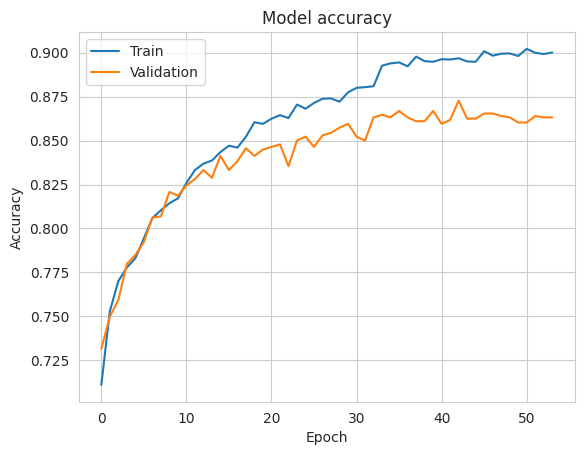

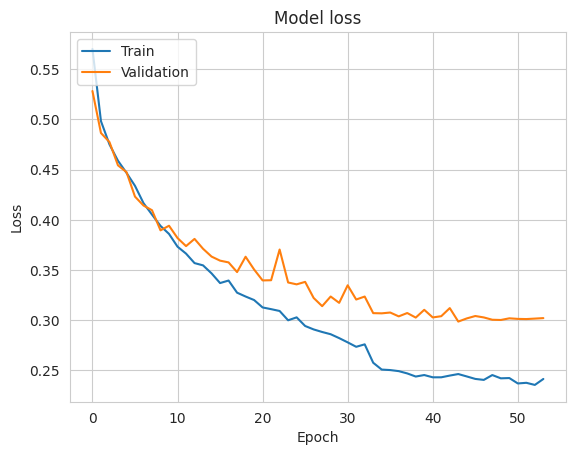

In [132]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Error Analysis

In [133]:
# Get the predicted probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary predictions using a threshold (default is 0.5)
y_pred = (y_pred_probs > 0.5).astype(int)

# Get the actual predictions and the indices where the predictions were incorrect
incorrect_indices = np.where(y_pred.flatten() != y_test)[0]


48/48 [==============================] - 0s 1ms/step


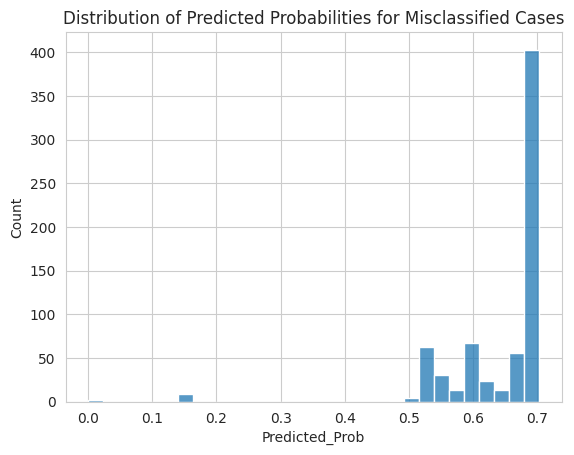

In [134]:
# Creating a DataFrame to compare actual labels and predicted probabilities/predictions
errors_df = pd.DataFrame({'Actual': y_test, 'Predicted_Prob': y_pred_probs.flatten(), 'Predicted': y_pred.flatten()})
errors_df['Error'] = errors_df['Actual'] != errors_df['Predicted']

# Extract the subset of the DataFrame where predictions are incorrect
misclassified = errors_df[errors_df['Error']]

# Filter out the misclassified cases
misclassified = errors_df[errors_df['Error']]

# Analyze the distribution of probabilities for misclassified cases
sns.histplot(misclassified['Predicted_Prob'], bins=30, kde=False)
plt.title('Distribution of Predicted Probabilities for Misclassified Cases')
plt.show()


In [135]:
# Cases where the model was very wrong
high_confidence_errors = misclassified[(misclassified['Predicted_Prob'] > 0.9) | (misclassified['Predicted_Prob'] < 0.1)]
X_test_errors = X_test.loc[high_confidence_errors.index]

# Check for common features among high confidence errors
common_features = X_test_errors.mean() - X_test.mean()

# This would give you the top 5 features with the highest divergence
top_divergent_features = common_features.abs().sort_values(ascending=False).head(5).index.tolist()
print(top_divergent_features)


['smoking_status', 'glucose_bins', 'bmi_bins', 'Residence_type', 'gender']


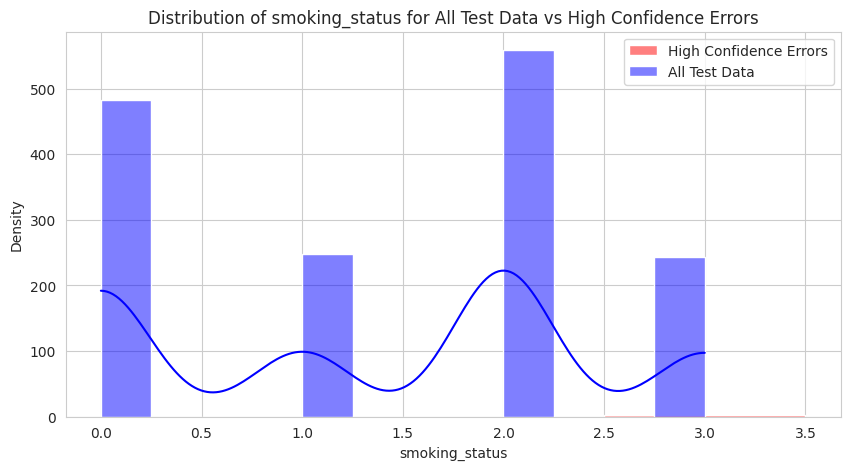

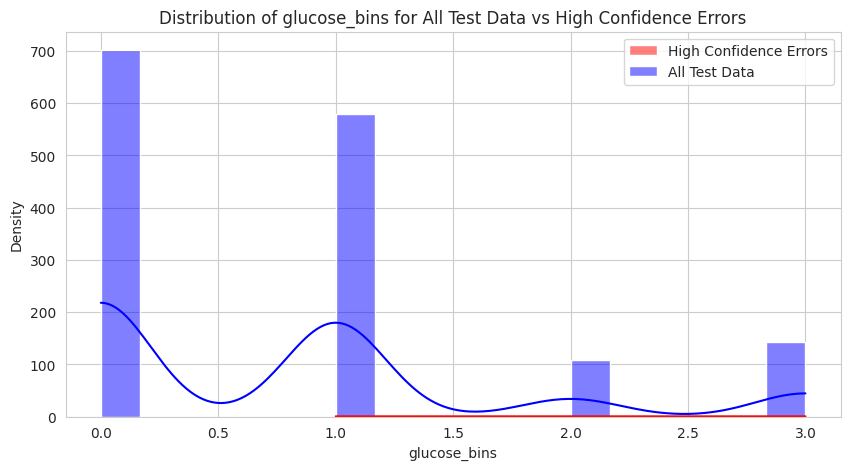

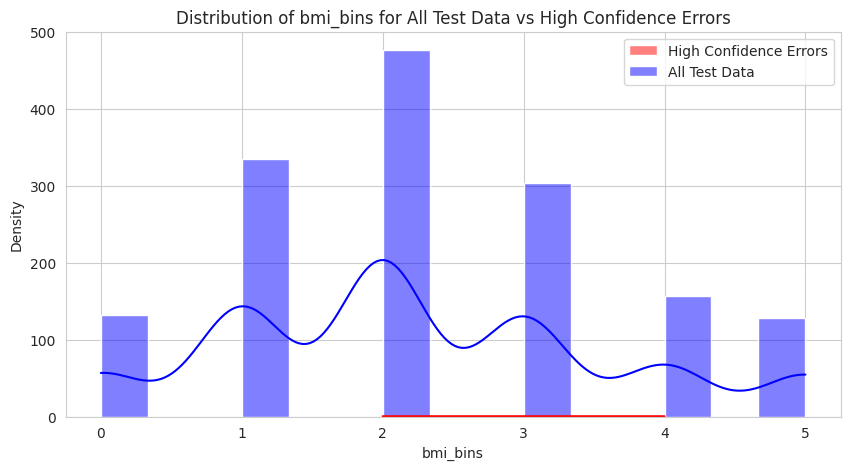

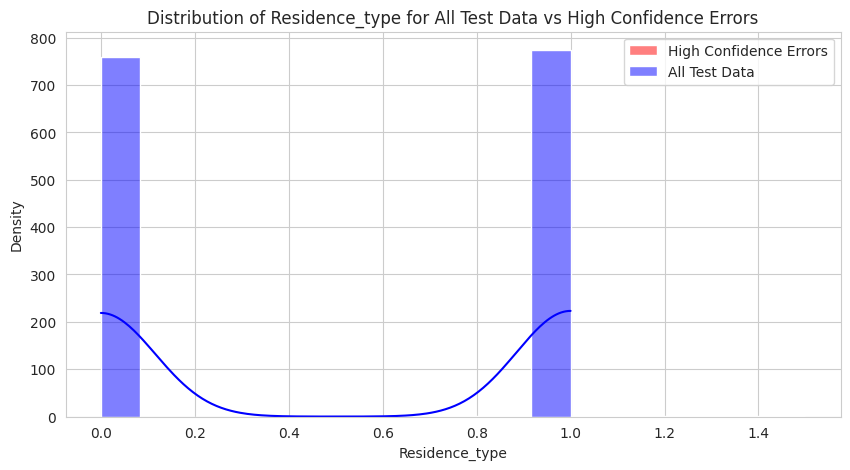

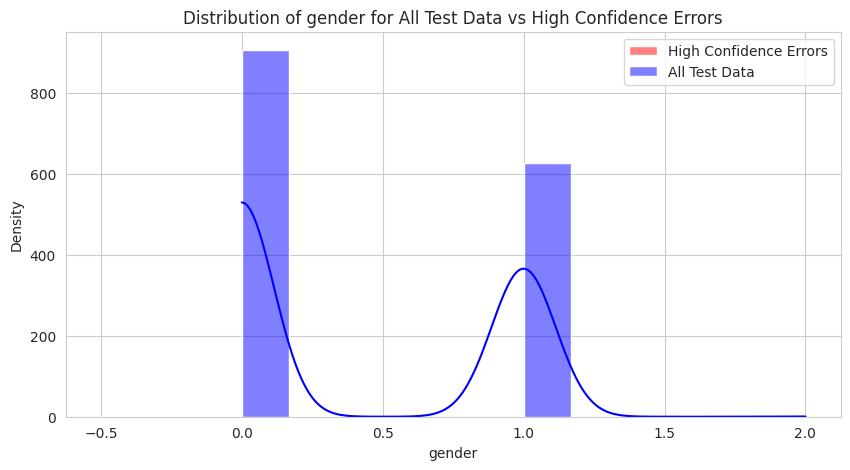

In [136]:
for feature in top_divergent_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(X_test_errors[feature], color='red', label='High Confidence Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='All Test Data', kde=True)
    plt.title(f'Distribution of {feature} for All Test Data vs High Confidence Errors')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


<ipython-input-137-c7cb8606608e>:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_test_errors[feature], label='Errors', fill=True)


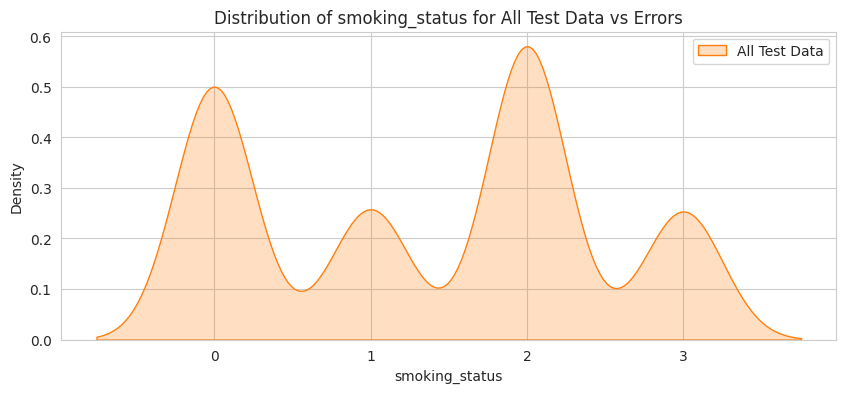

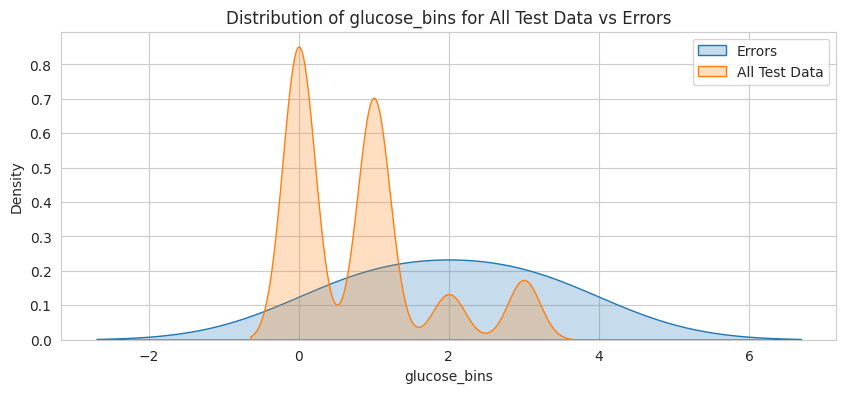

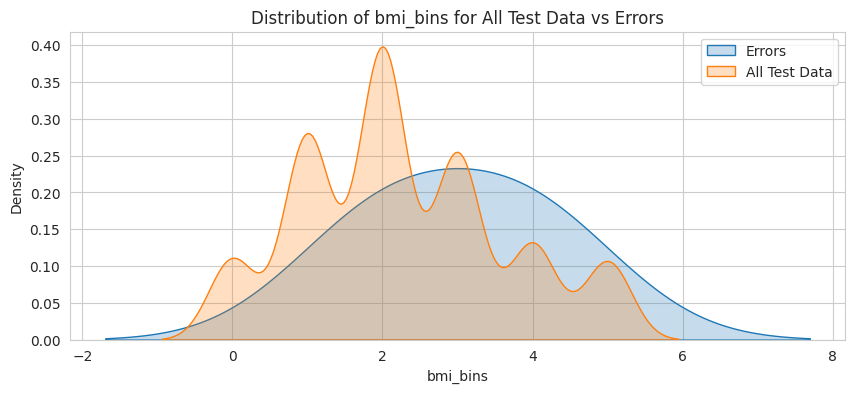

<ipython-input-137-c7cb8606608e>:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_test_errors[feature], label='Errors', fill=True)


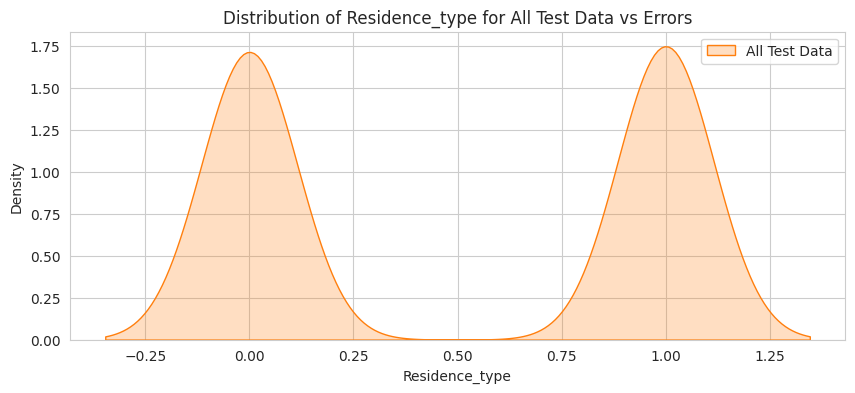

<ipython-input-137-c7cb8606608e>:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_test_errors[feature], label='Errors', fill=True)


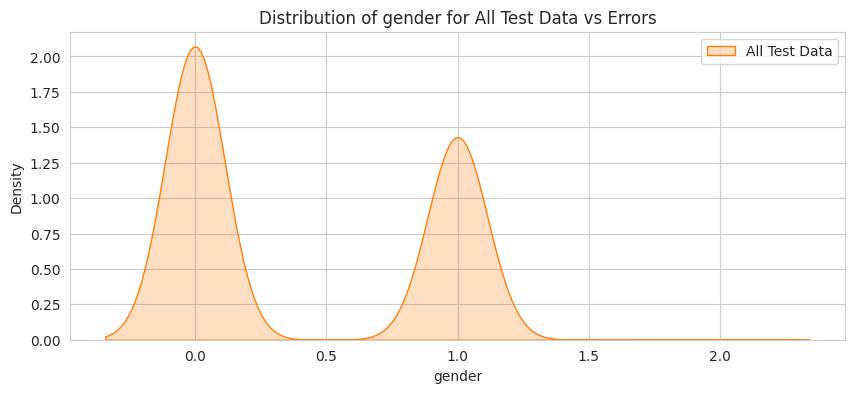

In [137]:
# Assuming 'high_confidence_errors' is a DataFrame with cases where the model was very wrong
for feature in common_features.sort_values(key=abs, ascending=False).index[:5]:  # Top 5 features
    plt.figure(figsize=(10, 4))
    sns.kdeplot(X_test_errors[feature], label='Errors', fill=True)
    sns.kdeplot(X_test[feature], label='All Test Data', fill=True)
    plt.title(f'Distribution of {feature} for All Test Data vs Errors')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


In [138]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Assume y_test are the true labels and model_predictions are the predictions from the model
# Replace model.predict(X_test) with your model's prediction method
model_predictions = (model.predict(X_test) > 0.5).astype("int32")

precision = precision_score(y_test, model_predictions)
recall = recall_score(y_test, model_predictions)
f1 = f1_score(y_test, model_predictions)
roc_auc = roc_auc_score(y_test, model.predict(X_test))

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {roc_auc}")


48/48 [==============================] - 0s 2ms/step
Precision: 0.10252996005326231
Recall: 0.8651685393258427
F1-Score: 0.18333333333333332
AUC-ROC: 0.766799464658097
